# Bayesian Model Averaging Logistic Regression

In this notebook we will use Bayesian Model Averaging (BMA) to understand a logistic regression problem.  The data coronary heart disease (0 = does not have CHD, 1 = has CHD), depending on a number of medical predictor variables.

In [1]:
import numpy as np 
import pandas as pd 
import statsmodels.api as sm
from statsmodels.tools import add_constant
from itertools import combinations
from sklearn.model_selection import train_test_split

Load the data, and check the head.

In [2]:
df = pd.read_csv('/kaggle/input/coronary-heart-disease/CHDdata.csv')
df["famhist"] = (df["famhist"] == "Present")*1 # converts the famhit to 0 (no hist) and 1 (has hist)
#df = df.drop(["famhist"], axis=1)
df.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


In [3]:
X = df.drop(["chd"], axis=1)
y = df["chd"]
# building the model and fitting the data 
log_reg = sm.Logit(y, add_constant(X)).fit()
log_reg.summary()

Optimization terminated successfully.
         Current function value: 0.510974
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    chd   No. Observations:                  462
Model:                          Logit   Df Residuals:                      452
Method:                           MLE   Df Model:                            9
Date:                Mon, 06 Nov 2023   Pseudo R-squ.:                  0.2080
Time:                        06:43:07   Log-Likelihood:                -236.07
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 2.055e-22
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -6.1507      1.308     -4.701      0.000      -8.715      -3.587
sbp            0.0065      0.006      1.135      0.256      -0.005       0.018
tobacco        0.0794      0.027      2.984      0.003       0.027       0.132
ldl            0.1739      0.060      2.915      0.004       0.057       0.291
adiposity      0.0186      0.029      0.635      0.526      -0.039       0.076
famhist        0.9254      0.228      4.061      0.000       0.479       1.372
typea          0.0396      0.012      3.214      0.001       0.015       0.064
obesity       -0.0629      0.044     -1.422      0.155      -0.150       0.024
alcohol        0.0001      0.004      0.027      0.978      -0.009       0.009
age            0.0452      0.012      3.728      0.000       0.021       0.069
==============================================================================
"""

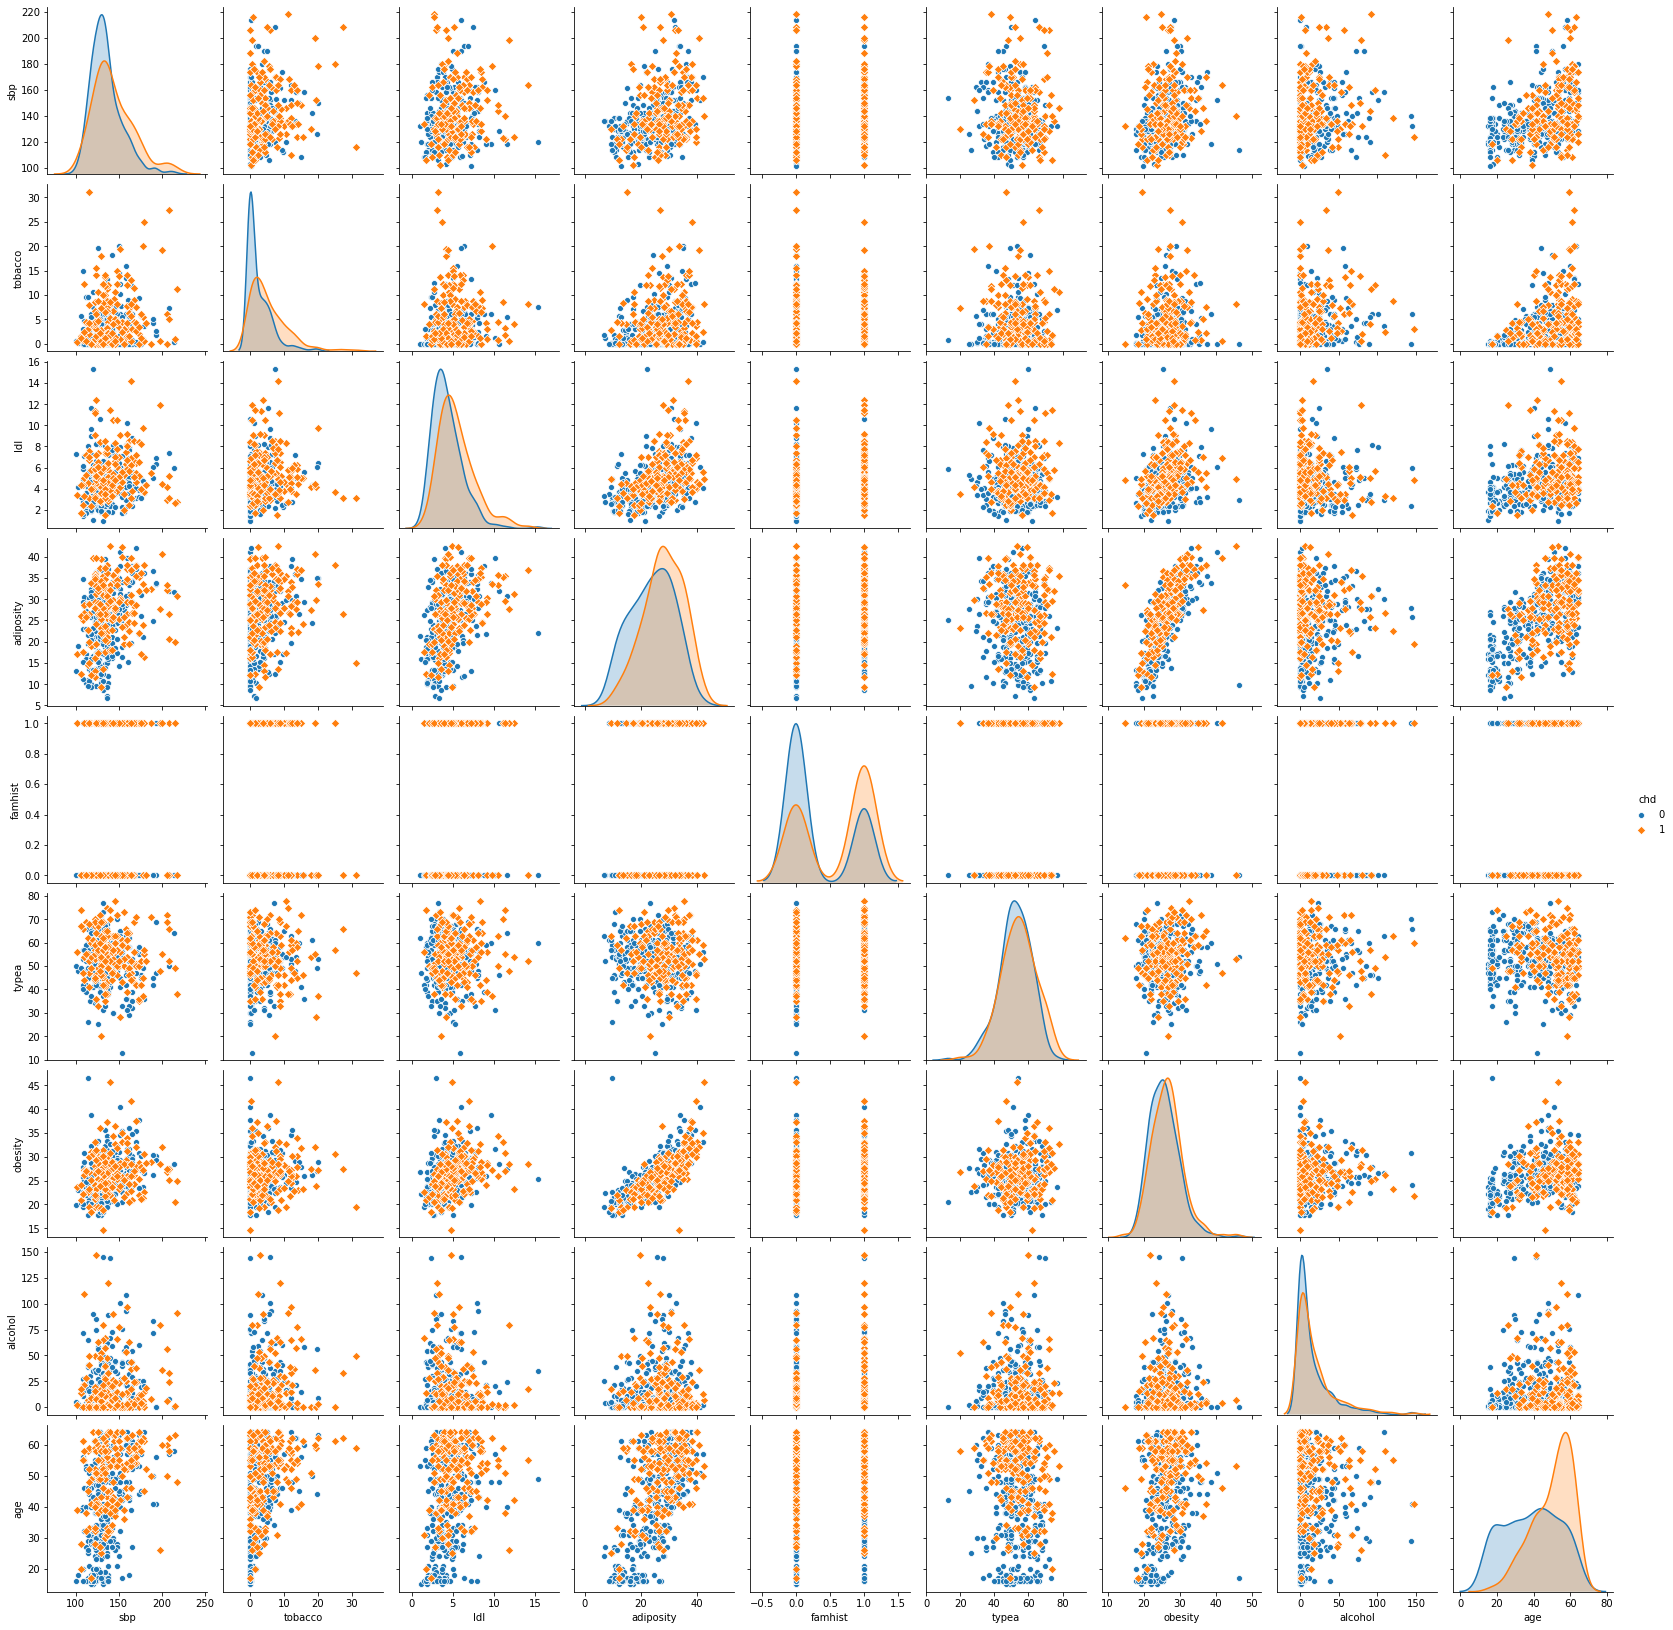

In [4]:
# Seaborn visualization library
import seaborn as sns
# Create the default pairplot
g = sns.pairplot(df, hue="chd", palette="tab10", markers=["o", "D"])

# Bayesian Model Averaging
Here we define the class that will perform our BMA analysis.

For any model $M_i$ (each model is defined by the set of predictor varialbes being used in the model), Bayes theorem tells us that the probability for $M_i$ is
\begin{equation}
p(M_i|X,y)=\frac{p(X,y|M_i)p(M_i)}{p(X,y)}.
\end{equation}

Using our previous formulas, this becomes,
\begin{equation}
p(M_i|X,y)=\frac{e^{−\text{BIC}_i/2}p(M_i)}{\sum_k e^{−\text{BIC}_k/2}p(M_k)}.
\end{equation}

So far, we have just done Bayesian analysis to compute a posterior probability distribution on the parameters.  But now we can do more with the 'averaging' part of BMA.

The probability for any predictor variable is the sum of the probabilities for all models contiaining that predictor variable, and the expected value for the coefficient of the predictor variable is the average value of the coefficient over all models containing the variable, weighted by the probability of each model.  That is,
\begin{equation}
p(X_k) = \sum_{M_i \text{such that } X_k\in M_i} p(M_i|X,y),
\end{equation}
and
\begin{equation}
E[\beta_k] = \sum_{M_i \text{such that } X_k\in M_i} p(M_i|X,y)\times \beta_k^{(i)},
\end{equation}
where $\beta_k^{(i)}$ is the coefficient of $X_k$ in model $M_i$.

Here is code for a BMA class that will do the Bayeisan Model Averaging.  This is the same as the code from the Bayesian Model Averaging notebook https://www.kaggle.com/billbasener/bayesian-model-averaging-regression-tutorial-pt-2, but with that added capability to do logistic regression via the keyword RegType to "Logit".

In [5]:
from mpmath import mp
mp.dps = 50
class BMA:
    
    def __init__(self, y, X, **kwargs):
        # Setup the basic variables.
        self.y = y
        self.X = X
        self.names = list(X.columns)
        self.nRows, self.nCols = np.shape(X)
        self.likelihoods = mp.zeros(self.nCols,1)
        self.likelihoods_all = {}
        self.coefficients_mp = mp.zeros(self.nCols,1)
        self.coefficients = np.zeros(self.nCols)
        self.probabilities = np.zeros(self.nCols)
        # Check the max model size. (Max number of predictor variables to use in a model.)
        # This can be used to reduce the runtime but not doing an exhaustive sampling.
        if 'MaxVars' in kwargs.keys():
            self.MaxVars = kwargs['MaxVars']
        else:
            self.MaxVars = self.nCols  
        # Prepare the priors if they are provided.
        # The priors are provided for the individual regressor variables.
        # The prior for a model is the product of the priors on the variables in the model.
        if 'Priors' in kwargs.keys():
            if np.size(kwargs['Priors']) == self.nCols:
                self.Priors = kwargs['Priors']
            else:
                print("WARNING: Provided priors error.  Using equal priors instead.")
                print("The priors should be a numpy array of length equal tot he number of regressor variables.")
                self.Priors = np.ones(self.nCols)  
        else:
            self.Priors = np.ones(self.nCols)  
        if 'Verbose' in kwargs.keys():
            self.Verbose = kwargs['Verbose'] 
        else:
            self.Verbose = False 
        if 'RegType' in kwargs.keys():
            self.RegType = kwargs['RegType'] 
        else:
            self.RegType = 'LS' 
        
    def fit(self):
        # Perform the Bayesian Model Averaging
        
        # Initialize the sum of the likelihoods for all the models to zero.  
        # This will be the 'normalization' denominator in Bayes Theorem.
        likelighood_sum = 0
        
        # To facilitate iterating through all possible models, we start by iterating thorugh
        # the number of elements in the model.  
        max_likelihood = 0
        for num_elements in range(1,self.MaxVars+1): 
            
            if self.Verbose == True:
                print("Computing BMA for models of size: ", num_elements)
            
            # Make a list of all index sets of models of this size.
            Models_next = list(combinations(list(range(self.nCols)), num_elements)) 
             
            # Occam's window - compute the candidate models to use for the next iteration
            # Models_previous: the set of models from the previous iteration that satisfy (likelihhod > max_likelihhod/20)
            # Models_next:     the set of candidate models for the next iteration
            # Models_current:  the set of models from Models_next that can be consturcted by adding one new variable
            #                    to a model from Models_previous
            if num_elements == 1:
                Models_current = Models_next
                Models_previous = []
            else:
                idx_keep = np.zeros(len(Models_next))
                for M_new,idx in zip(Models_next,range(len(Models_next))):
                    for M_good in Models_previous:
                        if(all(x in M_new for x in M_good)):
                            idx_keep[idx] = 1
                            break
                        else:
                            pass
                Models_current = np.asarray(Models_next)[np.where(idx_keep==1)].tolist()
                Models_previous = []
                        
            
            # Iterate through all possible models of the given size.
            for model_index_set in Models_current:
                
                # Compute the linear regression for this given model. 
                model_X = self.X.iloc[:,list(model_index_set)]
                if self.RegType == 'Logit':
                    model_regr = sm.Logit(self.y, model_X).fit(disp=0)
                else:
                    model_regr = OLS(self.y, model_X).fit()
                
                # Compute the likelihood (times the prior) for the model. 
                model_likelihood = mp.exp(-model_regr.bic/2)*np.prod(self.Priors[list(model_index_set)])
                    
                if (model_likelihood > max_likelihood/20):
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"likelihood=",model_likelihood)
                    self.likelihoods_all[str(model_index_set)] = model_likelihood
                    
                    # Add this likelihood to the running tally of likelihoods.
                    likelighood_sum = mp.fadd(likelighood_sum, model_likelihood)

                    # Add this likelihood (times the priors) to the running tally
                    # of likelihoods for each variable in the model.
                    for idx, i in zip(model_index_set, range(num_elements)):
                        self.likelihoods[idx] = mp.fadd(self.likelihoods[idx], model_likelihood, prec=1000)
                        self.coefficients_mp[idx] = mp.fadd(self.coefficients_mp[idx], model_regr.params[i]*model_likelihood, prec=1000)
                    Models_previous.append(model_index_set) # add this model to the list of good models
                    max_likelihood = np.max([max_likelihood,model_likelihood]) # get the new max likelihood if it is this model
                else:
                    if self.Verbose == True:
                        print("Model Variables:",model_index_set,"rejected by Occam's window")
                    

        # Divide by the denominator in Bayes theorem to normalize the probabilities 
        # sum to one.
        self.likelighood_sum = likelighood_sum
        for idx in range(self.nCols):
            self.probabilities[idx] = mp.fdiv(self.likelihoods[idx],likelighood_sum, prec=1000)
            self.coefficients[idx] = mp.fdiv(self.coefficients_mp[idx],likelighood_sum, prec=1000)
        
        # Return the new BMA object as an output.
        return self
    
    def predict(self, data):
        data = np.asarray(data)
        if self.RegType == 'Logit':
            try:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data)))
            except:
                result = 1/(1+np.exp(-1*np.dot(self.coefficients,data.T)))
        else:
            try:
                result = np.dot(self.coefficients,data)
            except:
                result = np.dot(self.coefficients,data.T)
        
        return result  
        
    def summary(self):
        # Return the BMA results as a data frame for easy viewing.
        df = pd.DataFrame([self.names, list(self.probabilities), list(self.coefficients)], 
             ["Variable Name", "Probability", "Avg. Coefficient"]).T
        return df  

Now we split our data into input X dataframe and an output y datafram, and run our BMA analysis.

In [6]:
result = BMA(y,add_constant(X), RegType = 'Logit', Verbose=True).fit()

Computing BMA for models of size:  1
Model Variables: (0,) likelihood= 1.6764102335645664532888791099307451474533902752729e-131
Model Variables: (1,) rejected by Occam's window
Model Variables: (2,) rejected by Occam's window
Model Variables: (3,) rejected by Occam's window
Model Variables: (4,) rejected by Occam's window
Model Variables: (5,) rejected by Occam's window
Model Variables: (6,) rejected by Occam's window
Model Variables: (7,) likelihood= 1.1464455128442806768198208070714121692330734959133e-132
Model Variables: (8,) rejected by Occam's window
Model Variables: (9,) rejected by Occam's window
Computing BMA for models of size:  2
Model Variables: [0, 1] likelihood= 3.4444089502039875528984166990602644229227462409023e-129
Model Variables: [0, 2] likelihood= 7.8558801053145200455561371696708113598483547330823e-124
Model Variables: [0, 3] rejected by Occam's window
Model Variables: [0, 4] rejected by Occam's window
Model Variables: [0, 5] rejected by Occam's window
Model Variabl

In [7]:
summary_table = result.summary().sort_values(by = 'Probability')
summary_table

,Variable Name,Probability,Avg. Coefficient
8,alcohol,0,0
4,adiposity,0.0283248,-0.000267513
1,sbp,0.0569565,0.000336024
7,obesity,0.0588813,-0.00221377
3,ldl,0.833053,0.137145
6,typea,0.886594,0.0331735
2,tobacco,0.910225,0.0735926
5,famhist,0.998919,0.913329
9,age,1,0.0514433
0,const,1,-6.1127


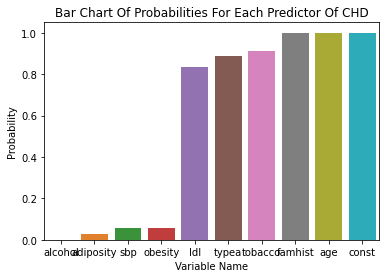

In [8]:
from matplotlib import pyplot as plt
import seaborn as sns

sns.barplot(x = 'Variable Name', y = 'Probability', data = summary_table)
plt.title('Bar Chart Of Probabilities For Each Predictor Of CHD')
plt.show()

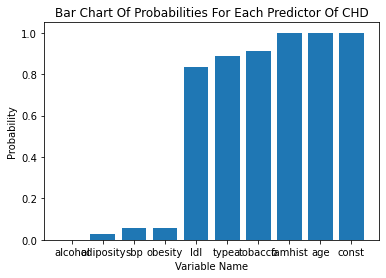

In [9]:
plt.bar(x = summary_table['Variable Name'], height = summary_table['Probability'])
plt.xlabel('Variable Name')
plt.ylabel('Probability')
plt.title('Bar Chart Of Probabilities For Each Predictor Of CHD')
plt.show()

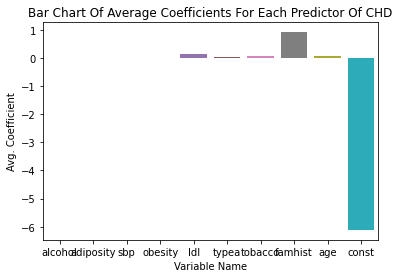

In [10]:
import seaborn as sns
sns.barplot(x = 'Variable Name', y = 'Avg. Coefficient', data = summary_table)
plt.title('Bar Chart Of Average Coefficients For Each Predictor Of CHD')
plt.show()

In [11]:
import scipy

print(X)
list_of_continuous_predictors = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']
for column in list_of_continuous_predictors:
    X[column] = scipy.stats.zscore(X[column])
print(X)

     sbp  tobacco    ldl  adiposity  famhist  typea  obesity  alcohol  age
0    160    12.00   5.73      23.11        1     49    25.30    97.20   52
1    144     0.01   4.41      28.61        0     55    28.87     2.06   63
2    118     0.08   3.48      32.28        1     52    29.14     3.81   46
3    170     7.50   6.41      38.03        1     51    31.99    24.26   58
4    134    13.60   3.50      27.78        1     60    25.99    57.34   49
..   ...      ...    ...        ...      ...    ...      ...      ...  ...
457  214     0.40   5.98      31.72        0     64    28.45     0.00   58
458  182     4.20   4.41      32.10        0     52    28.61    18.72   52
459  108     3.00   1.59      15.23        0     40    20.09    26.64   55
460  118     5.40  11.61      30.79        0     64    27.35    23.97   40
461  132     0.00   4.82      33.41        1     62    14.70     0.00   46

[462 rows x 9 columns]
          sbp   tobacco       ldl  adiposity  famhist     typea   obesity  \

In [12]:
result = BMA(y,add_constant(X), RegType = 'Logit', Verbose=True).fit()

Computing BMA for models of size:  1
Model Variables: (0,) likelihood= 1.6764102335645664532888791099307451474533902752729e-131
Model Variables: (1,) rejected by Occam's window
Model Variables: (2,) likelihood= 5.5041331106332466807468447191369457964419817844282e-132
Model Variables: (3,) rejected by Occam's window
Model Variables: (4,) rejected by Occam's window
Model Variables: (5,) rejected by Occam's window
Model Variables: (6,) rejected by Occam's window
Model Variables: (7,) rejected by Occam's window
Model Variables: (8,) rejected by Occam's window
Model Variables: (9,) likelihood= 6.3543675035883107674697838329159714464746233681068e-128
Computing BMA for models of size:  2
Model Variables: [0, 1] likelihood= 3.4444089502041833448791010659055678957873780955378e-129
Model Variables: [0, 2] likelihood= 7.8558801053149666006394838642055991926996948969225e-124
Model Variables: [0, 3] rejected by Occam's window
Model Variables: [0, 4] rejected by Occam's window
Model Variables: [0, 5

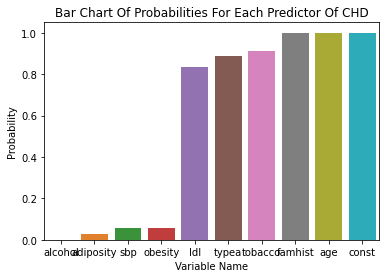

In [13]:
sns.barplot(x = 'Variable Name', y = 'Probability', data = summary_table)
plt.title('Bar Chart Of Probabilities For Each Predictor Of CHD')
plt.show()

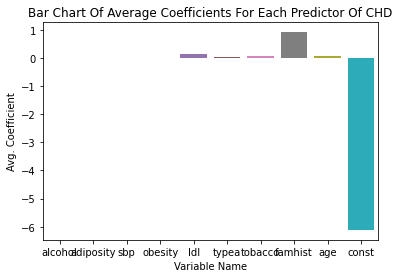

In [14]:
sns.barplot(x = 'Variable Name', y = 'Avg. Coefficient', data = summary_table)
plt.title('Bar Chart Of Average Coefficients For Each Predictor Of CHD')
plt.show()

Our Bar Charts Of Probabilities Of Predictors Of CHD are the same for non-standardized and standardized data. Our Bar Charts Of Average Coefficients For Each Predictor Of CHD are the same for non-standardized and standardized data.

In [15]:
# For comparison
log_reg.params

const       -6.150721
sbp          0.006504
tobacco      0.079376
ldl          0.173924
adiposity    0.018587
famhist      0.925370
typea        0.039595
obesity     -0.062910
alcohol      0.000122
age          0.045225
dtype: float64

In [16]:
r = result.summary()

In [17]:
r['Variable Name']

0        const
1          sbp
2      tobacco
3          ldl
4    adiposity
5      famhist
6        typea
7      obesity
8      alcohol
9          age
Name: Variable Name, dtype: object

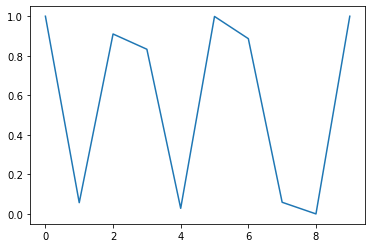

In [18]:
import matplotlib.pyplot as plt
plt.plot(r['Probability'])

In [19]:
result.likelihoods

matrix(
[['9.5576122860469157809088655574116307202403179684272e-112'],
 ['5.4436813855055058219326338779304898878685695236881e-113'],
 ['8.6995823886378498748661230503229042380477846634795e-112'],
 ['7.9619964770932897382127328119101066075472476991052e-112'],
 ['2.7071741267357347944539320610669541019257907456072e-113'],
 ['9.5472807411109875206191386338440003573907075698075e-112'],
 ['8.4737233212742995987533128315776148566108097404127e-112'],
 ['5.627647120182793430059164095769193248435091452943e-113'],
 ['0.0'],
 ['9.5576110477282426314769491355045711240912703218171e-112']])

In [20]:
result.likelihoods_all

{'(0,)': mpf('1.6764102335645664532888791099307451474533902752729417e-131'),
 '(2,)': mpf('5.5041331106332466807468447191369457964419817844282409e-132'),
 '(9,)': mpf('6.3543675035883107674697838329159714464746233681067536e-128'),
 '[0, 1]': mpf('3.4444089502041833448791010659055678957873780955377789e-129'),
 '[0, 2]': mpf('7.8558801053149666006394838642055991926996948969225431e-124'),
 '[0, 9]': mpf('1.6253490931655119684986769518658637546980939526697636e-117'),
 '[0, 1, 9]': mpf('1.3275414219044666920370459907363419417597103078934094e-118'),
 '[0, 2, 5]': mpf('1.2383108178701516212887392067651433267689657998342768e-118'),
 '[0, 2, 9]': mpf('1.2259928160939787764607775795744252962621006285181762e-116'),
 '[0, 3, 9]': mpf('5.2434159176293495654362746585168729037351662007347339e-116'),
 '[0, 5, 9]': mpf('9.6297916807520603269745697992121789168188145374368945e-115'),
 '[0, 1, 5, 9]': mpf('9.0855212860049926113666620825941860093722418653510362e-116'),
 '[0, 2, 3, 9]': mpf('3.0459561269781

In [21]:
# predict the y-values from training input data
pred_BMA = result.predict(add_constant(X))
pred_Logit = log_reg.predict(add_constant(X))

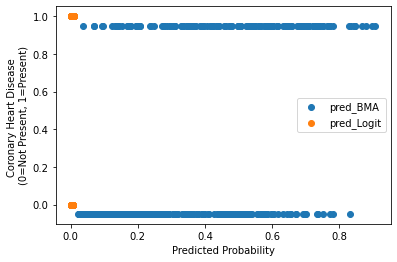

In [22]:
# plot the predictions with the actual values
import matplotlib.pyplot as plt
plt.scatter(pred_BMA,y-0.05)
plt.scatter(pred_Logit,y)
plt.xlabel("Predicted Probability")
plt.ylabel("Coronary Heart Disease \n(0=Not Present, 1=Present)")
plt.legend(['pred_BMA','pred_Logit'])

In [23]:
# compute accuracy
print("BMA Accuracy: ", np.sum((pred_BMA > 0.5) == y)/len(y))
print("Logit Accuracy: ", np.sum((pred_Logit > 0.5) == y)/len(y))

BMA Accuracy:  0.7424242424242424
Logit Accuracy:  0.6536796536796536


# Compare with test-train split

In [24]:
# build test-train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
# trian on training data 
log_reg = sm.Logit(y_train, add_constant(X_train)).fit()
result = BMA(y_train,add_constant(X_train), RegType = 'Logit', Verbose=False).fit()
# predict the y-values from test data
pred_BMA = result.predict(add_constant(X_test))
pred_Logit = log_reg.predict(add_constant(X_test))
# compute accuracy
print("BMA Accuracy: ", np.sum((pred_BMA > 0.5) == y_test)/len(y_test))
print("Logit Accuracy: ", np.sum((pred_Logit > 0.5) == y_test)/len(y_test))

Optimization terminated successfully.
         Current function value: 0.515459
         Iterations 6
BMA Accuracy:  0.7482014388489209
Logit Accuracy:  0.7410071942446043


Effects of regularization when the size of the training set is small include increasing BMA Accuracy by a small amount from 0.742 to 0.748, increase Logit Accuracy by a significant amount from 0.654 to 0.741, and narrow the gap between the models in terms of accuracy.

In [25]:
! pip install lazypredict
from lazypredict.Supervised import LazyClassifier, LazyRegressor

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [26]:
# fit all models
clf = LazyClassifier(predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

100%|██████████| 29/29 [00:00<00:00, 32.35it/s]


In [27]:
models

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken
Model,,,,,
SVC,0.76,0.70,0.70,0.75,0.01
SGDClassifier,0.73,0.69,0.69,0.72,0.01
NearestCentroid,0.68,0.68,0.68,0.68,0.01
NuSVC,0.74,0.68,0.68,0.73,0.02
GaussianNB,0.70,0.68,0.68,0.70,0.02
LinearSVC,0.73,0.68,0.68,0.72,0.03
LinearDiscriminantAnalysis,0.73,0.68,0.68,0.72,0.01
LogisticRegression,0.73,0.68,0.68,0.72,0.01
Perceptron,0.68,0.67,0.67,0.68,0.01


In [28]:
## from: https://towardsdatascience.com/exploratory-data-analysis-with-pandas-profiling-de3aae2ddff3 
from IPython.display import IFrame
import IPython
from pandas_profiling import ProfileReport
prof = ProfileReport(df)
prof.to_file(output_file='output_ProfileReport.html')